Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Explore MCMC Sampling

## Environment Setup

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Background

#### Notation:
- $\theta$ = the parameters of a model
- $D$ = the data, or evidence

#### Our Goal:
Understand the probability of our model, $\theta$, given our new data, $D$. We call this the **posterior**.
<center>$p(\theta|D)$</center>

Try that again....

What is the distribution of our model parameters that explains the new data?

And again ...

What is the shape of our models parameters that accounts for our new evidence?

#### Bayes Theorem:

<center>
$p(\theta|D) = \dfrac{p(D|\theta) \cdot p(\theta)}{p(D)}$
</center>

#### Repeated in helpful terms:

<center>
$\textrm{posterior} = \dfrac{\textrm{likelihood}\cdot\textrm{prior}}{\textrm{data}}$
</center>

#### Motivation
We want to understand the **posterior** but it may be complex.  If we integrate the right-hand side we can do this.  What can you do when you cannot integrate one of the parts?  We can approximate by sampling.

#### Obstacles
The data/evidence can be particularly tricky:
<center>
$p(D) = \int p(D|\theta) p(\theta) d\theta$
</center>

#### Solutions
- Conjugate priors: closed form solutions where posterior has same distribution as prior
- Numerical integration
- Variational Bayes: approximate functions to calculate the posterior to show approximate posterior is close the ture posterior
- MCMC Sampling Methods: Our exploration here!


## A Simple Problem

A single proportion.  The number of successes / number of attempts.

The possible range of values for rate is [0,1].

In [ ]:
rate = np.arange(0,1,0.001)

Our prior belief is based on seeing 2 successes in 10 tries

In [ ]:
prior_success = 2
prior_failure = 8

We can represent our prior beliefs with the Beta disribution:

In [ ]:
prior_beta = stats.beta(prior_success,prior_failure)

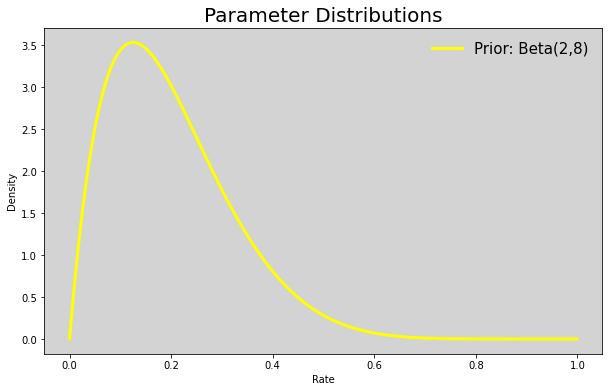

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")
plt.plot(rate,prior_beta.pdf(rate),label="Prior: Beta({},{})".format(prior_success,prior_failure), color='yellow', linewidth=3)
plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Parameter Distributions', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=15)
fig.show()

A new set of data/tries shows 3 successes out of 10 tries:

In [ ]:
data_success = 3
data_failure = 7

Similarly, we can express the likelihood with a Binomial distribution:

In [ ]:
likelihood_binom = stats.binom(data_success+data_failure,rate)

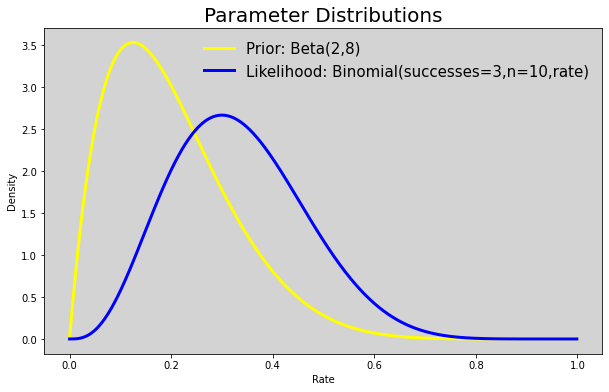

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")
plt.plot(rate,prior_beta.pdf(rate),label="Prior: Beta({},{})".format(prior_success,prior_failure), color='yellow', linewidth=3)
plt.plot(rate,(data_success+data_failure)*likelihood_binom.pmf(data_success),label="Likelihood: Binomial(successes={},n={},rate)".format(data_success,data_success+data_failure), color='blue', linewidth=3)
plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Parameter Distributions', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=15)
fig.show()

## Conjugate Priors
If we use a Beta distribution for the **posterior**, the same as we used for the **prior**, then we call these conjugate distributions.  The Beta **prior** is called a conjugate **prior** for the **likelihood** which is a Binomial is this example.

Calculating the Beta posterior is simple, add the success and failure for the prior information and the current data/evidence:

In [ ]:
posterior_beta = stats.beta(prior_success+data_success,prior_failure+data_failure)

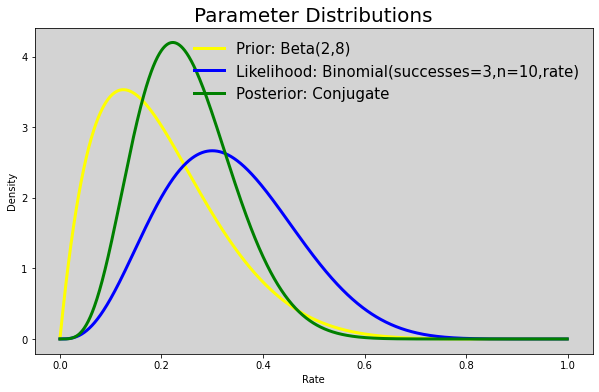

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")
plt.plot(rate,prior_beta.pdf(rate),label="Prior: Beta({},{})".format(prior_success,prior_failure), color='yellow', linewidth=3)
plt.plot(rate,(data_success+data_failure)*likelihood_binom.pmf(data_success),label="Likelihood: Binomial(successes={},n={},rate)".format(data_success,data_success+data_failure), color='blue', linewidth=3)
plt.plot(rate,posterior_beta.pdf(rate),label="Posterior: Conjugate", color='green', linewidth=3)
plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Parameter Distributions', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=15)
fig.show()

## Numerical Integration
Idea: Estimate value on a a grid of $\theta$.  This grid is already stored in the variable `rate`.

**Difficulty:** Our example is simple.  As the number of parameters increases, the number of grid points is $n^t$, where n is the grid resolution and t is the number of parameters.

Evalute the grid stored in `rate` for the **prior** and **likelihood**.  To complete the calculation we need $P(D)$.  In this case, we can sum across the grid of $P(D|\theta)P(\theta)$, **likelihood * prior**.

In [ ]:
posterior_ni = prior_beta.pdf(rate) * likelihood_binom.pmf(data_success)
posterior_ni /= (posterior_ni.sum()/len(rate))

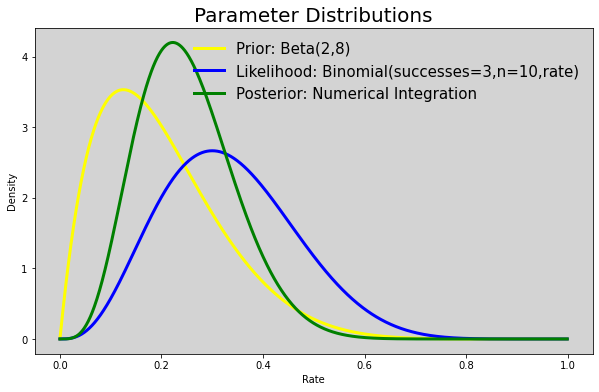

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")
plt.plot(rate,prior_beta.pdf(rate),label="Prior: Beta({},{})".format(prior_success,prior_failure), color='yellow', linewidth=3)
plt.plot(rate,(data_success+data_failure)*likelihood_binom.pmf(data_success),label="Likelihood: Binomial(successes={},n={},rate)".format(data_success,data_success+data_failure), color='blue', linewidth=3)
plt.plot(rate,posterior_ni,label="Posterior: Numerical Integration", color='green', linewidth=3)
plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Parameter Distributions', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=15)
fig.show()

## Sampling

What happens when the prior is not an easily described distribution?  What happens when conjugate priors are not possible and numerical integration is not feasible?  We can sample from the posterior!

We desire to sample from the **posterior** by sampling from:
<center>
$\textrm{posterior} = \dfrac{\textrm{likelihood}\cdot\textrm{prior}}{\textrm{data}}$
</center>

But, the **data** part is a hard to compute marginal likelihood.

Good news, it is basically a normalizing constant

We call our distribution a target distribution because it only needs to be proportional to the actual **posterior**

**Target**:
<center>
$\textrm{posterior} \propto \textrm{likelihood}\cdot\textrm{prior}$
</center>

In [ ]:
def target(theta,prior):
  if np.isscalar(theta):
    if theta < 0 or theta > 1:
      return 0
  else:
    theta[theta < 0] = 0
    theta[theta > 1] = 0

  lh = stats.binom.pmf(data_success,data_success+data_failure,theta)
  return lh * prior.pdf(theta)

## Rejection Sampler
The basic idea:
- define the space of the posterior using the **target**
- randomly select points in the space
- accept points under the posterior
- construct an empirical posterior from the accepted points

Draw samples from the space that contains the posterior:

In [ ]:
samples = 10000
x = np.random.uniform(rate.min(),rate.max(),samples).round(3)
y = np.random.uniform(target(rate,prior_beta).min(),target(rate,prior_beta).max(),samples).round(3)
points = np.vstack((x,y)).T
points[0:10]

array([[0.981, 0.473],
       [0.971, 0.292],
       [0.637, 0.494],
       [0.386, 0.365],
       [0.58 , 0.394],
       [0.625, 0.328],
       [0.143, 0.199],
       [0.311, 0.009],
       [0.918, 0.602],
       [0.28 , 0.448]])

Evaluate each point versus the posterior value:

In [ ]:
acceptance = points[:,1] <= [target(x,prior_beta) for x in points[:,0]]

Calculate the efficiency, or percentage of samples that were under the posterior:

In [ ]:
efficiency = len(acceptance[acceptance==True])/len(acceptance)
print("Efficiency of Rejection Sampling was {:.1%}".format(efficiency))

Efficiency of Rejection Sampling was 24.2%


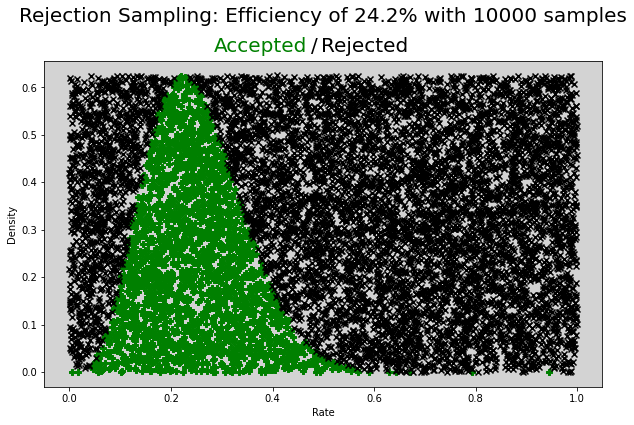

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")

plt.scatter(points[acceptance==True,0],points[acceptance==True,1],color='green',marker='P')
plt.scatter(points[acceptance==False,0],points[acceptance==False,1],color='black',marker='x')

plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Rejection Sampling: Efficiency of {:.1%} with {} samples'.format(efficiency,samples), fontsize=20, y=1.1, ha='center')
plt.figtext(0.49,.9, 'Accepted',fontsize=20, color='green', ha='right')
plt.figtext(0.51,0.9, 'Rejected',fontsize=20, color='black', ha='left')
plt.figtext(0.50,0.9, '/',fontsize=20, color='black', ha='center')
fig.show()

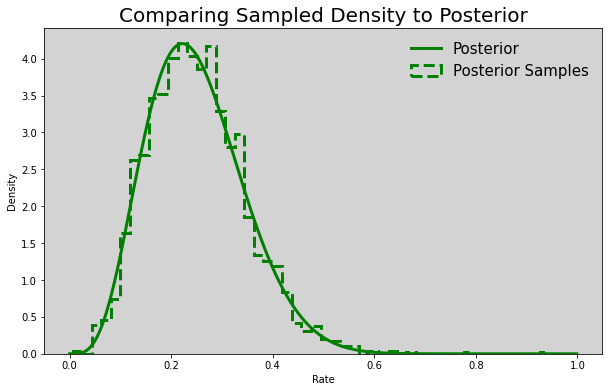

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")

plt.plot(rate,posterior_beta.pdf(rate),label="Posterior", color='green', linewidth=3)
plt.hist(points[acceptance==True,0], 50, histtype='step', density=True, linewidth=3, label='Posterior Samples', color='green', linestyle='--')

plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Comparing Sampled Density to Posterior', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=15)
fig.show()

## MCMC with Metropolis-Hastings Sampler
The Basic Idea:
- start with a value for theta
- move theta (step)
- evaluate the posterior of both values of theta
- if the step has a higher **target**, commit to the step (accept)
- if the step has a lower **target**, evaluate the ratio of new **target** to current **target** against a random acceptance ratio. (Random Walk)
- continue for the specified number of iterations
- a chain is made up of all the accepted steps
- efficiency is the number of accepted steps versus the number of attempted steps


### Sampling

In [ ]:
iterations = 1000
theta = 0.9

mh_sample = []
mh_rejected = []
for i in range(iterations):
  theta_step = np.random.normal(theta,0.1)
  acceptance_ratio = min(1, target(theta_step,prior_beta)/target(theta,prior_beta))
  decision = np.random.uniform()
  if decision < acceptance_ratio:
    theta = theta_step
    mh_sample.append(theta_step)
    mh_rejected.append(float('nan'))
  else:
    mh_sample.append(theta)
    mh_rejected.append(theta_step) 

efficiency = (len(mh_sample)-len([x for x in mh_rejected if np.isnan(x) == False]))/len(mh_sample)

### Review Samples

Trace the chain (iterations) and review the accepted and rejected steps that were considered:

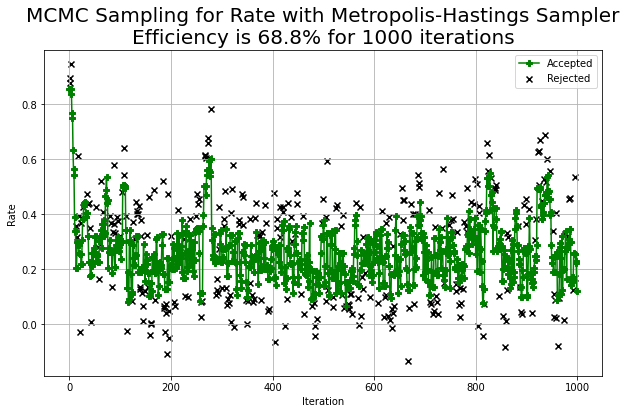

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(np.arange(len(mh_sample)),mh_sample,color='green',linestyle='-',marker='P',label='Accepted')
plt.scatter(np.arange(len(mh_rejected)),mh_rejected,color='black',marker='x', label='Rejected')

plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.grid()
plt.title('MCMC Sampling for Rate with Metropolis-Hastings Sampler\nEfficiency is {:.1%} for {} iterations'.format(efficiency,iterations), fontsize=20)
plt.legend(loc='best', frameon=True, fontsize=10)
fig.show()

Zoom in to the first 100 iterations to observe convergence behavior:

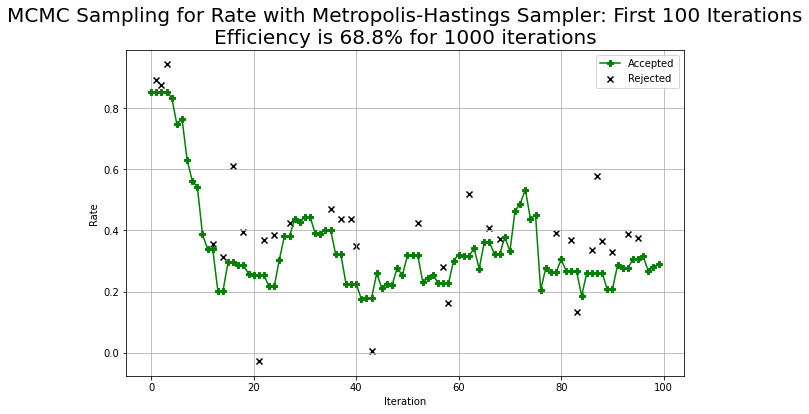

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
first = 100
plt.plot(np.arange(first),mh_sample[0:first],color='green',linestyle='-',marker='P',label='Accepted')
plt.scatter(np.arange(first),mh_rejected[0:first],color='black',marker='x', label='Rejected')

plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.grid()
plt.title('MCMC Sampling for Rate with Metropolis-Hastings Sampler: First {} Iterations\nEfficiency is {:.1%} for {} iterations'.format(first,efficiency,iterations), fontsize=20)
plt.legend(loc='best', frameon=True, fontsize=10)
fig.show()

Review only accepted steps and remove the first 100 (burn in):

In [ ]:
mh_accepted = [a for a,b in zip(mh_sample,mh_rejected) if np.isnan(b) == True]
burn = 100

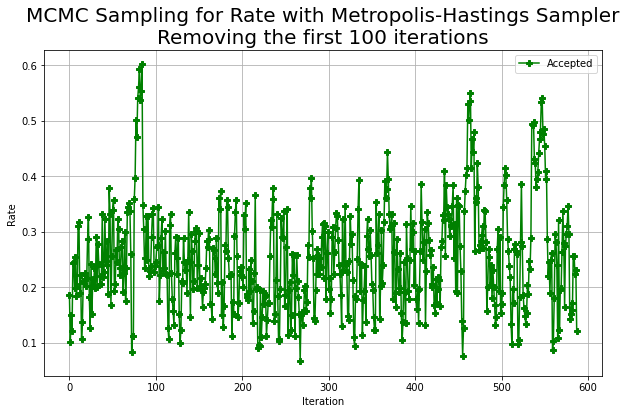

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(np.arange(len(mh_accepted[burn:])),mh_accepted[burn:],color='green',linestyle='-',marker='P',label='Accepted')

plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.grid()
plt.title('MCMC Sampling for Rate with Metropolis-Hastings Sampler\nRemoving the first {} iterations'.format(burn), fontsize=20)
plt.legend(loc='best', frameon=True, fontsize=10)
fig.show()

### Compare Accepted Samples to the Posterior

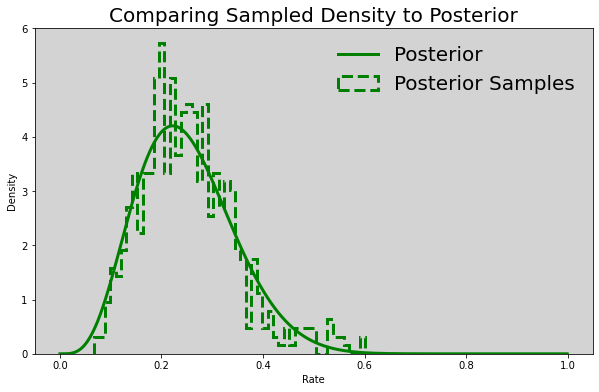

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")

plt.plot(rate,posterior_beta.pdf(rate),label="Posterior", color='green', linewidth=3)
plt.hist(mh_accepted[burn:], 50, histtype='step', density=True, linewidth=3, label='Posterior Samples', color='green', linestyle='--')

plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Comparing Sampled Density to Posterior', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=20)
fig.show()

### Try Multiple Chains

Make a function for our sampler:

In [ ]:
def mh_mcmc(iterations,theta):
  mh_sample = []
  mh_rejected = []
  for i in range(iterations):
    theta_step = np.random.normal(theta,0.1)
    acceptance_ratio = min(1, target(theta_step,prior_beta)/target(theta,prior_beta))
    decision = np.random.uniform()
    if decision < acceptance_ratio:
      theta = theta_step
      mh_sample.append(theta_step)
      mh_rejected.append(float('nan'))
    else:
      mh_sample.append(theta)
      mh_rejected.append(theta_step)
  return mh_sample, mh_rejected

Run multiple chains with the sampler, each with a different starting value for theta:

In [ ]:
chains = [mh_mcmc(1000,theta) for theta in np.arange(0.1,1,.1)]

#### Review the Chains

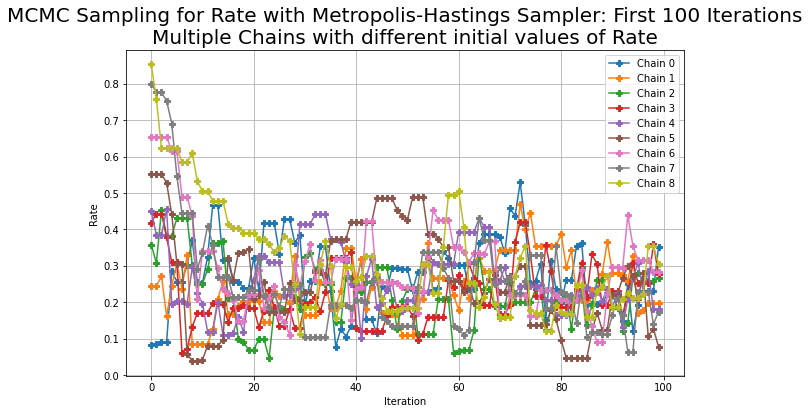

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

first = 100
for i, chain in enumerate(chains):
  plt.plot(np.arange(len(chain[0][0:first])),chain[0][0:first],linestyle='-',marker='P',label='Chain {}'.format(i))

plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.grid()
plt.title('MCMC Sampling for Rate with Metropolis-Hastings Sampler: First {} Iterations\nMultiple Chains with different initial values of Rate'.format(first), fontsize=20)
plt.legend(loc='best', frameon=True, fontsize=10)
fig.show()

#### Compare the Accepted Samples to the Posterior for each Chain

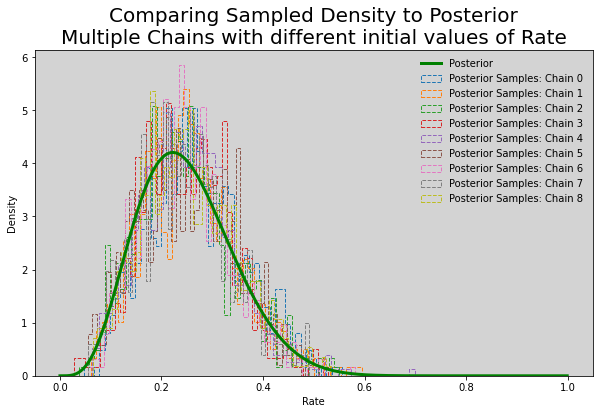

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")

plt.plot(rate,posterior_beta.pdf(rate),label="Posterior", color='green', linewidth=3)
for i, chain in enumerate(chains):
  mh_accepted = [a for a,b in zip(chain[0],chain[1]) if np.isnan(b) == True]
  burn = 100
  plt.hist(mh_accepted[burn:], 50, histtype='step', density=True, linewidth=1, label='Posterior Samples: Chain {}'.format(i), linestyle='--')

plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Comparing Sampled Density to Posterior\nMultiple Chains with different initial values of Rate', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=10)
fig.show()

#### Combine the Chains
Combine accepted samples from each chain, omitting the first 100 iterations

In [ ]:
burn = 100
mh_accepted = []
for chain in chains:
  chain_accepted = [a for a,b in zip(chain[0],chain[1]) if np.isnan(b) == True]
  mh_accepted += chain_accepted[burn:]

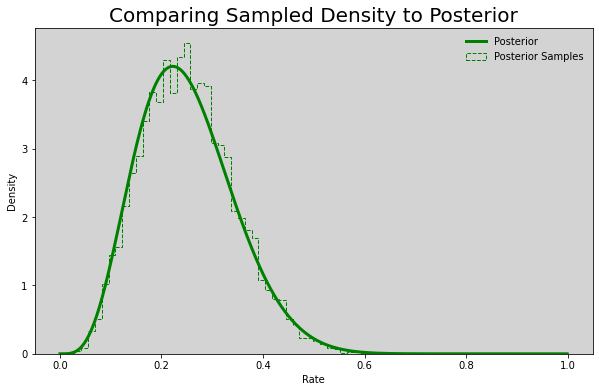

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_facecolor("lightgray")

plt.plot(rate,posterior_beta.pdf(rate),label="Posterior", color='green', linewidth=3)
plt.hist(mh_accepted, 50, histtype='step', density=True, linewidth=1, label='Posterior Samples', linestyle='--', color='green')

plt.xlabel('Rate')
plt.ylabel('Density')
plt.title('Comparing Sampled Density to Posterior', fontsize=20)
plt.legend(loc='best', frameon=False, fontsize=10)
fig.show()

## More!
- Computing
  - [PyMC3](https://docs.pymc.io/)
  - Stan with [PyStan](https://pystan.readthedocs.io/en/latest/)
  - [JAX](https://opensource.google/projects/jax)
  - Tensorflow Probability: [tfp.mcmc](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc)
    - [tfp.mcmc + JAX](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX#mcmc)

- Similar explorations:
  - https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html
  - https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a
  - http://people.duke.edu/~ccc14/sta-663/MCMC.html

  - tangent:
    - https://rlouf.github.io/post/jax-random-walk-metropolis/
    - https://www.countbayesie.com/blog/2015/6/20/tricky-priors-and-rejection-sampling


    